# **Amazon Product Recommendation System/Engine**

# Solution by: 'Femi Bolarinwa

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

As a Data Science Manager, I want to build a recommendation system to recommend products to customers based on their previous ratings for other products. I have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. I **will not use this column** to solve the current problem

## **Solution Notebook Content Overview:**
- **Libraries importation**
- **Data pre-processing**
- **Exploratory Data Analysis**
- **Model Training, Validation and Evaluation**
    - **Model 1 - Rank/Popularity Based Recommendation System**
    - **Model 2 - User-User Similarity Based Recommendation System(Collaborative Filtering)**
    - **Model 3 - Item-Item Similarity Based Recommendation System(Collaborative Filtering)**
    - **Model 4 - Bi-clustering (Co-clustering) Based Recommendation System**
    - **Model 5 - Matrix-Factorization (latent features) Based Recommendation System**
- **Model Comparison**
- **Conclusion and Recommendation**

###Mounting Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [ ]:
#To ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe manipulation
import numpy as np
import pandas as pd

# Basic libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

 #Library for performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

### **Loading the data**

In [ ]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_Electronics.csv', header = None) # There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] # Adding column names

df = df.drop('timestamp', axis = 1) # Dropping timestamp

df_copy = df.copy(deep = True) # Copying the data to another DataFrame

**As this dataset is very large and has 7,824,482 observations, it is not computationally advisable to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, i can reduce the dataset by considering certain logical assumptions.**

Here, i will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have more number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

In [ ]:
# Checking the number of rows and columns
rows, columns = df_final.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  65290
No of columns:  3


**observations**
- 65,290 rows meets the logical assumption described above
- The 3 columns (user, product and rating) sufficient to build the user-item interation matrix

### **Data types**

In [ ]:
# Checking Data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**observations:**
- All columns have expected datatypes

### **Checking for missing values**

In [ ]:
# Checking for missing values present
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**observations here:**
- Missing values

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable
df_final['rating'].describe().T

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**observations:**
- Average product rating of 4.3, Median rating of 5
- Slightly left skewed
- At least 50% of ratings were 5

### **Checking the rating distribution**

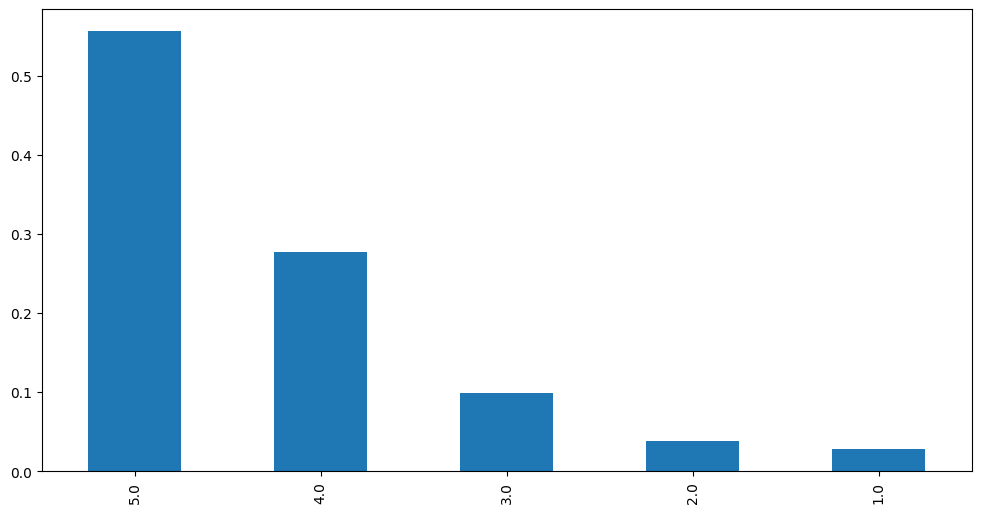

In [ ]:
# Creating the bar plot and provide observations
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(2).plot(kind = 'bar')

plt.show()

**observations:**
- More than 80% of ratings were 5 or 4
- Appears items are generally liked

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

- The highest number of **ratings by a user is 295** which is far from the actual number of products (5689) present in the data. I'll build a recommendations system to recommend products to users which they have not interacted with.

## **Model 1: Popularity/Rank Based Recommendation System**

This is a type of recommendation system where best rated items/products are recommended to users. Its ideal for cold start for new users who do not have any history

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


### Next Steps:

- **Create product ranking based on average rating**
- **Adjust product ranking with rating counts**
- **Create custom function for top_n_products prediction**
- **Recommending top 5 products with 50 minimum interactions based on popularity**
- **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
#average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

#count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#dataframe with calculated average rating and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sorting the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending = False)

# top ten records of the "final_rating" dataset
final_rating.head(10)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8
B003CK10DG,5.0,5
B003B41XYO,5.0,5
B0007WK8KS,5.0,6
B0084FM5JC,5.0,5


**Correction/Adjustment of the Ratings and Ranking of the above Items**

While comparing the ratings of two items, it is not only the ratings that describe the likelihood of the user to interact with that item. Along with the rating, the number of users who have interacted with it also become important to consider. Due to this, i will calculate the "corrected_rating" for each item. Generally, the higher the "rating_count" of a item, the more reliable the rating is. To interpret the above concept, a item rated 4 with rating_count 3 is less liked in comparison to a item rated 3 with a rating count of 50. It has been empirically found that the likelihood of an item is directly proportional to the inverse of the square root of the rating_count of the item.

In [ ]:
#average rating for each product
average_rating = df_final.groupby('prod_id').mean()['rating']

#count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

#correcting/adjusting ratings
final_rating['corrected_rating'] = final_rating['avg_rating'] - 1 / np.sqrt(final_rating['rating_count'])

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('corrected_rating', ascending = False)

# top 10 records of the "final_rating" dataset
final_rating.head(10)

,avg_rating,rating_count,corrected_rating
prod_id,,,
B0052SCU8U,4.979592,49,4.836735
B003ES5ZUU,4.864130,184,4.790409
B000FQ2JLW,5.000000,19,4.770584
B001TH7T2U,4.925000,40,4.766886
B00ISFNSBW,5.000000,18,4.764298
B00BQ4F9ZA,4.911111,45,4.762040
B001TH7GUU,4.871795,78,4.758567
B001TH7GUA,5.000000,17,4.757464
B00HZWJGS8,5.000000,17,4.757464


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions

def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

## **Collaborative Filtering Recommendation System**

In this type of recommendation system, `we do not need any information` about the users or items. I only need user-item interaction data to build a collaborative recommendation system. For example -
<ol>
    <li><b>Ratings</b> provided by users. For example, ratings of books on goodread, movie ratings on imdb, etc.</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos.</li>
    <li><b>Use/buying</b> of a product by users. For example, buying different items on e-commerce sites.</li>
    <li><b>Reading</b> of articles by readers on various blogs.</li>
</ol>

**Types of Collaborative Filtering**

- Similarity/Neighborhood based

 * User-User Similarity Based
 * Item-Item similarity based

- Model (Matrix Facorization) based

**Some basic terminologies in Recommendation Systems:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Custom function**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- i will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, testdataset, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testdataset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    #accuracy.rmse(predictions)

    #print('Precision: ', precision) # Command to print the overall precision

    #print('Recall: ', recall) # Command to print the overall recall

    #print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

    # Creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE":  round(accuracy.rmse(predictions),3),
            "MAE":  round(accuracy.mae(predictions),3),
            "Precision":  precision,
            "Recall":  recall,
            "f1-score": round((2*precision*recall)/(precision+recall), 3),
            #"Adj. R-squared": adjr2,
            #"MAPE": mape,
        },

        index = [1],
    )

    return df_perf


**Note:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.

Below i am loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, i will be **using the classes `Reader` and `Dataset`.**

In [ ]:
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset into required format for 'surprise' package
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

## **Model 2: user-user similarity based recommendation system**

- Below, i am building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.
- I will be using a machine learning library for recommendation systems, called `surprise`, to build the remaining models.

### **Next Steps**

- **Initialize the KNNBasic model using sim_options provided, Verbose=False, and setting random_state=1**

- **Fit the model on the training data**

- **Use the precision_recall_at_k function to calculate performance metrics on the unseen test data**

In [71]:
# Declaring the similarity options. 'True' for user-user, 'False' for item-item
sim_options = {'name': 'cosine',
               'user_based': True}

# Initializing the KNNBasic model using sim_options above, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = 1, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# model performance  (precision@k, recall@k, and f_1 score)on useen test data using the custome function (precision_recall_at_k) defined above
performance_u_u = precision_recall_at_k(sim_user_user, testset, k = 10, threshold = 3.5)
performance_u_u

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0012
MAE:  0.7094


,RMSE,MAE,Precision,Recall,f1-score
1,1.001,0.709,0.855,0.858,0.856


Observation:
- Recall: for all users in the unseen test data set, 85.8% of all top 10 actual rating (>3.5)  were correctly recommended (i.e. predicted rating >3.5)
- Precision: for all users in the unseen test data set, 85.5% of all top 10 recommendation (i.e. predicted rating >3.5)  were correct (i.e. actual rating >3.5)
- f1 - score: harmonic mean of recall and precision
- RMSE: root mean square error of top 10 rating predictions for all users in unseen test date is 1
- MAE: mean absolute error of top 10 rating predictions is 0.7

**Predicting rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5 which is denoted by the parameter r_ui.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**observations**
- model prediction is a false negative  since actual rating is 5 whereas predicted rating is lower than threshold (3.5)
- item predicted not to be relevant to user whereas it is

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A2ZR3YTMEEIIZ4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below i am predicting rating for `userId=A2ZR3YTMEEIIZ4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**observations:**
- Recommendation model predicts product is relevant to user

### **Improving Similarity-based Recommendation System by tuning its hyperparameters**

Below, i will be tuning hyperparameters for the `KNNBasic` algorithm. Some of the hyperparameters of the KNNBasic algorithm are:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40, 50, 60, 70], 'min_k': [2, 3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],
                              'user_based': [True]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse', 'mae'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9717102493177218
{'k': 60, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Now, let's build the **final model by using tuned values of the hyperparameters**, which i got by using **grid search cross-validation**.

In [72]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 70, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# model performance  (precision@k, recall@k, and f_1 score) on unseen test data using the custome function (precision_recall_at_k) defined above
performance_u_u_tuned = precision_recall_at_k(sim_user_user_optimized, testset, 10, 3.5)
performance_u_u_tuned

RMSE: 0.9526
MAE:  0.7277


,RMSE,MAE,Precision,Recall,f1-score
1,0.953,0.728,0.847,0.894,0.87


Observation:
- Tuned model performance is better than baseline model

#### **Next Steps:**
- **I'll predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **I'll predict rating for `userId="A2ZR3YTMEEIIZ4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **I'll compare the output with the output from the baseline model**

In [ ]:
# Using sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Using sim_user_user_optimized model to recommend for userId "A2ZR3YTMEEIIZ4" and productId "1400501466"
sim_user_user_optimized.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**observation:**
- Tuned model correctly predicts/recommends a relevant product (1400501466) to user "A3LDPF5FMB782Z" i.e. prediction is a true positive. Baseline model prediction was a false negative
- Tuned model recommends product "1400501466" to user "A2ZR3YTMEEIIZ4". Baseline model did too

### **Identifying similar Users to a given User (nearest neighbors)**

I can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below i will be implementing a custom function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" using user-user similarity based recommendation system**

In [59]:
# Making top 10 recommendations for user_id "A3LDPF5FMB782Z" with a user-user similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 10, sim_user_user_optimized)

In [60]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5.000000
1,B000BQ7GW8,5.000000
2,B001TH7GUU,5.000000
3,B005ES0YYA,5.000000
4,B00834SJSK,5.000000
5,B00E3W15P0,5.000000
6,B00006RVPW,5.000000
7,B004RORMF6,5.000000
8,B002WE6D44,4.937476
9,B000N99BBC,4.874904


**Correction/Adjustment of the Ratings and Ranking of the above Items**

In [ ]:
def ranking_items(recommendations, final_rating):

  # Sort the items based on ratings count
  ranked_items = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

  # Merge with the recommended items to get predicted ratings
  ranked_items = ranked_items.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

  # Rank the items based on corrected ratings
  ranked_items['corrected_ratings'] = ranked_items['predicted_ratings'] - 1 / np.sqrt(ranked_items['rating_count'])

  # Sort the items based on corrected ratings
  ranked_items = ranked_items.sort_values('corrected_ratings', ascending = False)

  return ranked_items

In [61]:
# Applying the ranking_items function and sorting it based on corrected ratings
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
1,B00834SJSK,101,5.000000,4.900496
3,B001TH7GUU,78,5.000000,4.886772
4,B000BQ7GW8,54,5.000000,4.863917
5,B00E3W15P0,48,5.000000,4.855662
6,B000067RT6,41,5.000000,4.843826
2,B002WE6D44,100,4.937476,4.837476
7,B004RORMF6,34,5.000000,4.828501
8,B00006RVPW,31,5.000000,4.820395
9,B005ES0YYA,26,5.000000,4.803884
0,B000N99BBC,167,4.874904,4.797522


## **Model 3: Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Previously we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now i'll look into similarity-based collaborative filtering where similarity is seen **between items**.

In [73]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# model performance  (precision@k, recall@k, and f_1 score) on unseen test data using the custom function (precision_recall_at_k) defined earlier
performance_i_i = precision_recall_at_k(sim_item_item, testset, 10, 3.5)
performance_i_i

RMSE: 0.9950
MAE:  0.7038


,RMSE,MAE,Precision,Recall,f1-score
1,0.995,0.704,0.838,0.845,0.841


**observations:**
Observation:
- Recall: for all users in the unseen test data set, 84.5% of all top 10 actual rating (>3.5)  were correctly recommended (i.e. predicted rating >3.5)
- Precision: for all users in the unseen test data set, 83.8% of all top 10 recommendation (i.e. predicted rating >3.5)  were correct (i.e. actual rating >3.5)
- f1 - score: harmonic mean of recall and precision
- RMSE: root mean square error of top 10 rating predictions for all users in unseen test date is ~1
- MAE: mean absolute error of top 10 rating predictions is 0.7

I'll **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`**. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**observations**
- model prediction is a true positive  since actual rating is 5 and predicted rating (4.27) is greater than threshold (3.5)
- item correctly predicted to be relevant to user

Next i'm **predicting rating for the `userId = A2ZR3YTMEEIIZ4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**observations**
- Model predicts user would like product

### **Hyperparameter tuning the item-item similarity-based model**

- The following parameters will be tuned:
  - 'k': [10, 20, 30, 50, 70, 90]]
  - 'min_k': [2, 3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine', 'pearson','pearson_baseline']]
  - 'user_based': [False]
- GridSearchCV() to tune the model using the 'rmse' measure
- I'll print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 50, 70, 90], 'min_k': [2, 3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine', 'pearson','pearson_baseline'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse','mae'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.975145147378106
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9750308476024562
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Now let's build the **final model** by using **tuned values of the hyperparameters** which i got from the grid search cross-validation.

In [74]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE for users in the unseen test data
performance_i_i_tuned = precision_recall_at_k(sim_item_item_optimized, testset, 10, 3.5)
performance_i_i_tuned

RMSE: 0.9576
MAE:  0.7205


,RMSE,MAE,Precision,Recall,f1-score
1,0.958,0.721,0.839,0.88,0.859


**Observation**
- Slight improvement in model performance after hyper-parameter tuning

### **Next Steps:**
- I'll **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- And then **Predict rating for `userId="A2ZR3YTMEEIIZ4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2ZR3YTMEEIIZ4" and productId "1400501466"

sim_item_item_optimized.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**observation:**
- Tuned model correctly predicts/recommends a relevant product (1400501466) to user "3LDPF5FMB782Z" i.e. prediction is a true positive
- Both baseline and tuned models predicts user "A2ZR3YTMEEIIZ4" would like product "1400501466"

### **Identifying similar items to a given item (nearest neighbors)**

I can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with item-item similarity based recommendation system.**

In [63]:
# Making top 10 recommendations for user_id A1A5KUIIIHFF4U with item-item similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 10, sim_item_item_optimized)

In [64]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024
5,B00000JDF5,4.292024
6,B00000JDF6,4.292024
7,B00000K135,4.292024
8,B00000K4KH,4.292024
9,B00001P4XA,4.292024


In [65]:
# Applying the ranking_items function and sorting it based on corrected ratings
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00001P4XA,12,4.292024,4.003349
1,9983891212,8,4.292024,3.938471
2,B00000J1V5,7,4.292024,3.914060
3,B00000JDF5,7,4.292024,3.914060
4,B00000JDF6,7,4.292024,3.914060
5,1400532655,6,4.292024,3.883776
6,1400599997,5,4.292024,3.844810
7,B00000DM9W,5,4.292024,3.844810
8,B00000K135,5,4.292024,3.844810
9,B00000K4KH,5,4.292024,3.844810


## **Model 4: Bi-clustering Recommendation System**

In clustering-based recommendation systems, we explore the similarities and differences in people's tastes in items based on how they rate different items. We cluster similar users together and recommend items to a user based on ratings from other users in the same cluster.

Co-clustering is a set of techniques in Cluster Analysis. Given some matrix A, we want to cluster rows of A and columns of A simultaneously, this is a common task for user-item matrices.

As it clusters both the rows and the columns simultaneously, it is also called bi-clustering. To understand the working of the algorithm, let A be m x n matrix, the goal is to generate co-clusters: a subset of rows that exhibit similar behavior across a subset of columns, or vice versa.

Co-clustering is defined as two map functions: rows -> row cluster indexes columns -> column cluster indexes.

These map functions are learned simultaneously. It is different from other clustering techniques where we cluster first the rows and then the columns.

In [75]:
# Using CoClustering algorithm
clust_baseline = CoClustering(random_state = 1)

# Training the algorithm on the train set
clust_baseline.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10 for users in the unseen test data
performance_u_i = precision_recall_at_k(clust_baseline, testset, 10, 3.5)
performance_u_i

RMSE: 0.9444
MAE:  0.6647


,RMSE,MAE,Precision,Recall,f1-score
1,0.944,0.665,0.853,0.821,0.837


I have calculated RMSE to check how far the overall predicted ratings are from the actual ratings.

Here F_1 score of the baseline model is ~ 0.84. It indicates that mostly recommended items were relevant, and relevant items were recommended. I will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

### **Next Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2ZR3YTMEEIIZ4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Using clust_baseline model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

clust_baseline.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.55   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.5454001258921153, details={'was_impossible': False})

Observation:
- Recommendation is true positive

In [ ]:
# Using clust_baseline model to recommend for userId "A2ZR3YTMEEIIZ4" and productId "1400501466"

clust_baseline.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 3.27   {'was_impossible': False}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=3.2726728531648437, details={'was_impossible': False})

Observation:
- Model predicts user would not like item

### **Improving Bi-clustering based recommendation system by tuning its hyperparameters**

Below, I will be tuning hyperparameters for the CoClustering algorithm. Different hyperparameters of this algorithm are:.

n_cltr_u (int) – Number of user clusters. The default value is 3.

n_cltr_i (int) – Number of item clusters. The default value is 3.

n_epochs (int) – Number of iteration of the optimization loop. The default value is 3.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 4, 5, 6,8,10], 'n_cltr_i': [3, 4, 5, 6,8,10], 'n_epochs': [3, 10, 20, 30, 40, 50]}

# Performing 3-Fold gridsearch cross-validation
gs = GridSearchCV(CoClustering, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Printing the best RMSE score
print(gs.best_score['rmse'])

# Printing the combination of parameters that gives the best RMSE score
print(gs.best_params['rmse'])

0.9651549917944089
{'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 3}


Once the grid search is complete, i can get the optimal values for each of those hyperparameters as shown above.

i will build final model by using tuned values of the hyperparameters received after using the Grid search cross-validation above.

In [76]:
# Using tuned Coclustering algorithm
clust_tuned = CoClustering(n_cltr_u = 3, n_cltr_i = 3, n_epochs = 3, random_state = 1)

# Training the algorithm on the train set
clust_tuned.fit(trainset)

# Let us compute precision@k, recall@k, and F_1 score with k = 10 for users in the unseen test data
performance_u_i_tuned = precision_recall_at_k(clust_tuned, testset, 10, 3.5)
performance_u_i_tuned

RMSE: 0.9423
MAE:  0.6639


,RMSE,MAE,Precision,Recall,f1-score
1,0.942,0.664,0.854,0.823,0.838


We can see that the F_1 score for tuned co-clustering model is slightly higher than the F_1 score for the baseline Co-clustering model.

### **Next Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2ZR3YTMEEIIZ4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use clust_tuned model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

clust_tuned.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.61   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.612222259549241, details={'was_impossible': False})

Observation:
- Tuned model giving slightly better prediction of rating than baseline model

In [ ]:
# Use clust_tuned model to recommend for userId "A2ZR3YTMEEIIZ4" and productId "1400501466"

clust_tuned.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 3.34   {'was_impossible': False}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=3.339494986821969, details={'was_impossible': False})

Observation:
Model predicts user would not like item. Same as the baseline model

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with bi-clustering based recommendation system.**

In [66]:
# Making top 10 recommendations for user_id "A3LDPF5FMB782Z" with a bi-clustering recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 10, clust_tuned)
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,9983891212,5
1,B00000JDF6,5
2,B00000K4KH,5
3,B00003G1RG,5
4,B00004SY4H,5
5,B00005AT7Y,5
6,B00005NIMJ,5
7,B00005T3H5,5
8,B00005U21H,5
9,B000067RVL,5


In [67]:
# Applying the ranking_items function and sorting it based on corrected ratings
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B000067RVL,12,5,4.711325
1,B00005NIMJ,9,5,4.666667
2,9983891212,8,5,4.646447
3,B00000JDF6,7,5,4.622036
4,B00005U21H,7,5,4.622036
5,B00003G1RG,6,5,4.591752
6,B00000K4KH,5,5,4.552786
7,B00004SY4H,5,5,4.552786
8,B00005AT7Y,5,5,4.552786
9,B00005T3H5,5,5,4.552786


## **Model 5: Matrix Factorization (Model-based) Recommendation system**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. It uses **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix** so the algorithm replaces it with zeros

In [77]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the train set
svd.fit(trainset)

# Using the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE for users in the unseen test data
performance_svd = precision_recall_at_k(svd, testset, 10, 3.5)
performance_svd

RMSE: 0.8882
MAE:  0.6530


,RMSE,MAE,Precision,Recall,f1-score
1,0.888,0.653,0.853,0.88,0.866


Observation:
- average rating deviates from actual rating by 0.653
- f1-score of 87%

**I'll now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**observations:**
- model prediction is a true positive

**Below i am predicting rating for the `userId = "A2ZR3YTMEEIIZ4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.2193138413482085, details={'was_impossible': False})

**observations:**
- Model predicts user would like item

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below i will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.9002527434236729
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.4}


Now, i will **the build final model** by using **tuned values** of the hyperparameters, which i received using grid search cross-validation above.

In [ ]:
# Building the optimized SVD model using optimal hyperparameter search. Use random_state = 1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.4, random_state = 1)

# Training the algorithm on the train set
svd_optimized = svd_optimized.fit(trainset)

# Using the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE for users in the unseen test data
performance_svd_tuned = precision_recall_at_k(svd_optimized, testset, 10, 3.5)
performance_svd_tuned

RMSE: 0.8822
MAE:  0.6561


,RMSE,MAE,Precision,Recall,f1-score
1,0.882,0.656,0.854,0.884,0.869


Observation:
- Model performance on unseen test data slightly improved after tuning

### **Next Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2ZR3YTMEEIIZ4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Using svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.04   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.0394144191097014, details={'was_impossible': False})

Observation:
- tuned model prediction is a true positive as baseline model

In [ ]:
# Using svd_algo_optimized model to recommend for userId "A2ZR3YTMEEIIZ4" and productId "1400501466"

svd_optimized.predict("A2ZR3YTMEEIIZ4", "1400501466", verbose = True)

user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = None   est = 4.08   {'was_impossible': False}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=None, est=4.080842067844753, details={'was_impossible': False})

Observation:
- model predicts user would like item. same as baseline model

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with Matrix-Factorization based recommendation system.**

In [68]:
# Making top 10 recommendations for user_id "A3LDPF5FMB782Z" with a matrix-factorization recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 10, svd_optimized)
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B00006HSYC,4.775916
1,B0010Y414Q,4.765719
2,B00AR95ESC,4.748074
3,B00IVPU6AA,4.734200
4,B002EEP3MK,4.733098
5,B000FQ2JLW,4.732380
6,B0033PRWSW,4.725349
7,B000JV9LUK,4.725264
8,B000F7QRTG,4.718166
9,B004ING996,4.716102


In [69]:
# Applying the ranking_items function and sorting it based on corrected ratings
ranking_items(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
1,B000FQ2JLW,19,4.732380,4.502964
0,B000F7QRTG,20,4.718166,4.494559
2,B0033PRWSW,15,4.725349,4.467150
3,B00IVPU6AA,14,4.734200,4.466939
4,B0010Y414Q,11,4.765719,4.464207
8,B00006HSYC,8,4.775916,4.422362
6,B00AR95ESC,9,4.748074,4.414741
5,B000JV9LUK,10,4.725264,4.409036
7,B002EEP3MK,9,4.733098,4.399765
9,B004ING996,6,4.716102,4.307854


##Comparing All Models' Performances on Unseen Test Data

In [78]:
#code to combine all model performance on unseen test data
models_test_comp_df = pd.concat(
    [
        performance_u_u.T,
        performance_u_u_tuned.T,
        performance_i_i.T,
        performance_i_i_tuned.T,
        performance_u_i.T,
        performance_u_i_tuned.T,
        performance_svd.T,
        performance_svd_tuned.T,
    ],
    axis = 1,
)

models_test_comp_df.columns = [
    "User-User similarity-based Model (default)",
    "User-User similarity-based Model (tuned)",
    "Item-Item similarity-based Model (default)",
    "Item-Item similarity-based Model (tuned)",
    "Bi-clustering Model (default)",
    "Bi-clustering Model (tuned)",
    "Matrix-Factorization Model",
    "Matrix-Factorization Model (tuned)",
   ]

print("Test performance comparison:")
round(models_test_comp_df,3).T.style.highlight_max(color = "lightgreen", axis = 0).highlight_min(color = "lightblue", axis = 0)

Test performance comparison:


,RMSE,MAE,Precision,Recall,f1-score
User-User similarity-based Model (default),1.001000,0.709000,0.855000,0.858000,0.856000
User-User similarity-based Model (tuned),0.953000,0.728000,0.847000,0.894000,0.870000
Item-Item similarity-based Model (default),0.995000,0.704000,0.838000,0.845000,0.841000
Item-Item similarity-based Model (tuned),0.958000,0.721000,0.839000,0.880000,0.859000
Bi-clustering Model (default),0.944000,0.665000,0.853000,0.821000,0.837000
Bi-clustering Model (tuned),0.942000,0.664000,0.854000,0.823000,0.838000
Matrix-Factorization Model,0.888000,0.653000,0.853000,0.880000,0.866000
Matrix-Factorization Model (tuned),0.882000,0.656000,0.854000,0.884000,0.869000


### **Conclusion and Recommendations**

The ultimate goal of a recommendation engine is to make predictions as close as possible to users' true taste. That means minimizing false positive and maximizing true positive as much as possible and therefore predicting ratings as close as possible to the true value.

In terms of performance metrics, this means lowest rating MAE/RMSE and highest f1-score on unseen test data.

For this project work, User-user similarity based model and Matrix Factorization Model (with tuned parameters) give the best performance. They would be my recommendations for implementation